In [7]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import shutil
from torch.utils.data import Dataset, DataLoader
from skimage import io
from torch.autograd import Variable
from scipy.stats import zscore
!pip install openpyxl
import pandas as pd
import time

In [8]:

table=pd.read_excel("../input/precusrsor/precurseur.xlsx")

dv_df=table
NaN_number=dv_df['C-Loss'].isnull().sum()
print(NaN_number)

#drop
dv_df= dv_df.dropna()
#rename columns
dv_df.columns = ["Sample","Charge","closs",dv_df.columns[3],"minutes",dv_df.columns[5]]
dv_df.head()


0


,Sample,Charge,closs,Cycles,minutes,dV
0,Ref_86,2xC,0.0,1,5,14.933152
1,Ref_86,2xC,0.0,1,6,14.957570
2,Ref_86,2xC,0.0,1,7,14.681274
3,Ref_86,2xC,0.0,1,8,14.969760
4,Ref_86,2xC,0.0,1,9,16.247636


In [9]:
def get_data(sample,cycle_number,num,seq_length):
  seq=dv_df.loc[dv_df["Sample"] == sample]
  cyc=seq.Cycles.unique()
  seq=seq.loc[seq["Cycles"] == cycle_number ]

  random_start=torch.randint(0,len(seq)-seq_length ,(num,)).numpy()
  data =torch.zeros((1,seq_length))
  target =torch.zeros((1,seq_length))
  for start in random_start:
    tmp=torch.tensor(seq.dV.iloc[start:start+seq_length].to_numpy())
    tmp1=torch.tensor(seq.closs.iloc[start:start+seq_length].to_numpy())
    data = torch.cat((data,tmp.unsqueeze(0)),0)
    target = torch.cat((target,tmp1.unsqueeze(0)),0)


  return data[1:,:],target[1:,:]



def make_dataset(samples,seq_length,num_per_cycle,shuffle = True ):
  data =torch.zeros((1,seq_length))
  target =torch.zeros((1,seq_length))
  for sample in samples:
    seq=dv_df.loc[dv_df["Sample"] == sample]
    cyc=seq.Cycles.unique()
    for cycle_number  in cyc :
      tmp1,tmp2=get_data(sample,cycle_number,num_per_cycle,seq_length)
      data = torch.cat((data,tmp1),0)
      target = torch.cat((target,tmp2),0)
  data = data[1:,:]
  target = target[1:,:]

  if shuffle:
    idx=torch.randperm(data.shape[0])
    return data[idx,:], target[idx,:] 
  return data, target

class LSTM(nn.Module):
    def __init__(self, hidden_layers=64,hidden_layers2=32):
        super(LSTM, self).__init__()
        
        self.lstm1 = nn.LSTMCell(1, hidden_layers)
        self.lstm2 = nn.LSTMCell(hidden_layers, hidden_layers2)
        self.linear = nn.Linear(hidden_layers2, 1)
        self.activ = nn.Sigmoid()
    def forward(self, y):
        outputs, n_samples = [], y.size(0)
        hidden_layers=model.lstm1.hidden_size
        hidden_layers2=model.lstm2.hidden_size
        h_t = torch.zeros(n_samples, hidden_layers, dtype=torch.float32).cuda()
        c_t = torch.zeros(n_samples, hidden_layers, dtype=torch.float32).cuda()
        h_t2 = torch.zeros(n_samples, hidden_layers2, dtype=torch.float32).cuda()
        c_t2 = torch.zeros(n_samples, hidden_layers2, dtype=torch.float32).cuda()
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) 
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) 
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)

            
        outputs = self.activ(torch.cat(outputs, dim=1))
        return outputs
    
def la_sauce(outputs,targets,alpha):
    out=abs(outputs-targets).sum(axis=0)/targets.shape[0]

    loss=((1-alpha)*torch.mean(out[:-1])+alpha*out[-1])
    return loss

In [10]:
#Upsample the data by overlapping sequences
# we'll have more overlap for shorter cycles

seq_length=20 #10 minutes
overlap=[0,4,5,6,7,8] #overlap for 10min of consecutive sequences
overlap = [int((seq_length/10)*o) for o in overlap]

print(overlap)
cycle_number=[0,50,200,400,600,800,1000]

print("charge rate 2xC",dv_df.loc[dv_df['Charge']=='2xC','Sample'].unique())
print("charge rate 4xC",dv_df.loc[dv_df['Charge']=='4xC','Sample'].unique())


#keep 'Ref_88' 'Ref_90' for testing to validate that the model didn't learn something specific to a cell in particular 
test_seq_names=['Ref_88','Ref_90']
train_seq_names=['Ref_86','Ref_87','Ref_86','Ref_92','Ref_91']

[0, 8, 10, 12, 14, 16]
charge rate 2xC ['Ref_86' 'Ref_87' 'Ref_88']
charge rate 4xC ['Ref_90' 'Ref_91' 'Ref_92']


In [39]:

train_seq_names=['Ref_86','Ref_86','Ref_92','Ref_91']
val_seq_names=['Ref_87']
test_seq_names=['Ref_88','Ref_90']

start = time.time()


train_array,train_target = make_dataset(train_seq_names,seq_length,50)
val_array ,val_target = make_dataset(val_seq_names,seq_length,50)
test_array ,test_target = make_dataset(test_seq_names,seq_length,50)
print(time.time()-start)

5.436761140823364


In [78]:
#hyperparameters

lr=0.001
gamma=0.6
step_size=200
alpha=0.5 #importance of last step  
train=1
load=0 
PATH="final_model.pth" #path to checkpoint
num_epochs=1600

In [79]:

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM().to(device)
model_initialisation=torch.save({'model' : model.state_dict()},"initialisation.pt")
optimiser = optim.Adam(model.parameters(), lr)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size, gamma)

In [80]:

def train(init_state, alpha,num_epochs=1200):
  val_error_hist1,train_loss_hist,val_loss_hist=[],[],[]
  model1 = LSTM().to(device)
  model1.load_state_dict(init_state) #same initialisation for comparison
  optimiser = optim.Adam(model1.parameters(), 5e-3)
  for epoch in range(num_epochs):
    train_data = train_array.to(device)
    target_data=train_target.to(device)
    # ===================forward=====================
    output = model1.train()(train_data.float())
    loss = la_sauce(output,target_data,alpha)
    # ===================backward====================
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    scheduler.step()

    val_output=model1.eval()(val_array.float().to(device))
    val_loss = la_sauce(val_output,val_target.to(device),alpha)

    train_loss_hist.append(loss.data)
    val_loss_hist.append(val_loss.data)
    tmp= 100*abs(val_output[:,-1]-val_target[:,-1].to(device))
    val_error_hist1.append(tmp.mean().cpu().detach().numpy())
    # ===================log========================
    if epoch%50==49:
      print('epoch [{}/{}], loss:{:.4f}, val loss:{:.4f}'
            .format(epoch + 1, num_epochs, loss.data, val_loss.data))
  return val_error_hist1,train_loss_hist,val_loss_hist,model1


state  = torch.load("initialisation.pt")

val_err1,_,_,model1=train(state["model"], 0.5)
val_err2,_,_,model2=train(state["model"], 1)
val_err3,_,_,model3=train(state["model"], 1/seq_length)
#torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [50/1200], loss:0.0600, val loss:0.0567
epoch [100/1200], loss:0.0380, val loss:0.0373
epoch [150/1200], loss:0.0329, val loss:0.0345
epoch [200/1200], loss:0.0329, val loss:0.0342
epoch [250/1200], loss:0.0314, val loss:0.0359
epoch [300/1200], loss:0.0316, val loss:0.0322
epoch [350/1200], loss:0.0318, val loss:0.0316
epoch [400/1200], loss:0.0294, val loss:0.0306
epoch [450/1200], loss:0.0275, val loss:0.0328
epoch [500/1200], loss:0.0237, val loss:0.0269
epoch [550/1200], loss:0.0290, val loss:0.0312
epoch [600/1200], loss:0.0226, val loss:0.0258
epoch [650/1200], loss:0.0209, val loss:0.0268
epoch [700/1200], loss:0.0192, val loss:0.0207
epoch [750/1200], loss:0.0229, val loss:0.0270
epoch [800/1200], loss:0.0182, val loss:0.0242
epoch [850/1200], loss:0.0185, val loss:0.0195
epoch [900/1200], loss:0.0162, val loss:0.0183
epoch [950/1200], loss:0.0178, val loss:0.0196
epoch [1000/1200], loss:0.0150, val loss:0.0161
epoch [1050/1200], loss:0.0145, val loss:0.0172
epoch [1100/

Text(0.5, 1.0, 'MAE along test sequences')

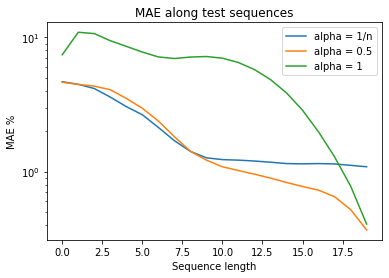

In [81]:
test_array=test_array.to(device)
test_target=test_target.to(device)
train_array=train_array.to(device)
train_target=train_target.to(device)

tmp1=abs(model1.eval()(test_array.float())-test_target).mean(0)
tmp2=abs(model2.eval()(test_array.float())-test_target).mean(0)
tmp3=abs(model3.eval()(test_array.float())-test_target).mean(0)

plt.semilogy(100*tmp3.cpu().detach(),label='alpha = 1/n')
plt.semilogy(100*tmp1.cpu().detach(),label='alpha = 0.5')
plt.semilogy(100*tmp2.cpu().detach(),label='alpha = 1')
plt.legend()

plt.xlabel("Sequence length")
plt.ylabel("MAE %")
plt.legend()
plt.title("MAE along test sequences")

Text(0.5, 1.0, 'End of sequence MAE during training (validation set)')

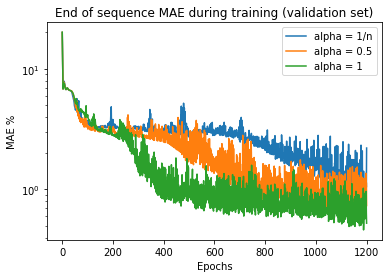

In [83]:


epoch=1200
plt.semilogy(np.linspace(0,epoch,epoch),val_err3[:epoch],label='alpha = 1/n')
plt.semilogy(np.linspace(0,epoch,epoch),val_err1[:epoch],label='alpha = 0.5')
plt.semilogy(np.linspace(0,epoch,epoch),val_err2[:epoch],label='alpha = 1')

plt.xlabel("Epochs")
plt.ylabel("MAE %")
plt.legend()
plt.title("End of sequence MAE during training (validation set)")

In [87]:
model=model1



tmp=abs(model.eval()(train_array.float())-train_target)[:,-1].mean()

print("Mean Absolute Error on training sequences: ",100*tmp.item(),"%")


tmp=abs(model.eval()(test_array.float())-test_target)[:,-1].mean()
print("Mean Absolute Error on test sequences: ",100*tmp.item(),"%")

Mean Absolute Error on training sequences:  0.4502550844473237 %
Mean Absolute Error on test sequences:  0.36739052207658096 %


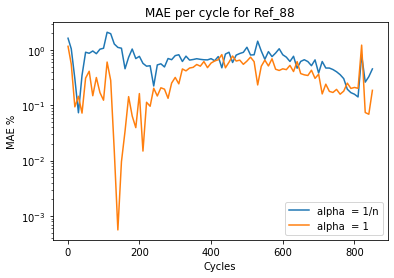

In [90]:
sample = "Ref_88"
cycles=dv_df.loc[dv_df["Sample"] == sample].Cycles.unique()
num=100
MAE_cycle3,MAE_cycle2=[],[]
responses3,responses2 =[],[]
targets=[]
for cycle_number in cycles:
    data,target=get_data(sample,cycle_number,num,seq_length)
    response2=model2.eval()(data.to(device).float())[:,-1].mean().item()
    response3  = model3.eval()(data.to(device).float())[:,-1].mean().item()
    responses3.append(response3)
    responses2.append(response2)
    targets.append(target[:,-1].mean().item())
    MAE_cycle3.append(100*abs(response3-target[:,-1].mean().item()))
    MAE_cycle2.append(100*abs(response2-target[:,-1].mean().item()))


plt.semilogy(cycles,MAE_cycle3,label="alpha  = 1/n")
plt.semilogy(cycles,MAE_cycle2,label="alpha  = 1")
plt.xlabel("Cycles")
plt.ylabel("MAE %")
plt.legend()
plt.title(f"MAE per cycle for {sample}")
plt.savefig(f'{sample}_MAE.jpg')

In [31]:

100*np.array(responses2)

array([ 1.33383004,  2.92943567,  2.39919685,  3.42926756,  2.92747468,
        4.29581217,  5.50717004,  5.47395535,  4.80294339,  4.26053144,
        5.75998947,  6.94647729,  6.5856494 ,  7.73103759,  7.97466636,
        7.89686665,  8.47547054,  8.84911194, 10.6377326 , 11.02059186,
       11.66434661, 11.55348942, 11.84327155, 12.61129826, 12.40444183,
       13.53012323, 13.5139659 , 14.48154449, 14.9603188 , 14.87807482,
       15.57663232, 16.36835635, 16.04461968, 16.48880243, 16.91192389,
       16.1078915 , 16.6010201 , 16.70297235, 17.49709845, 18.71062368,
       19.04711872, 19.2823872 , 18.54903847, 18.86962652, 19.83641833,
       18.56444925, 19.8022604 , 21.34796083, 22.2805351 , 22.59421945,
       22.00211734, 20.83500922, 23.30937535, 23.79123867, 23.69720638,
       23.10862839, 22.76647389, 24.64605421, 24.55706447, 23.55996966,
       25.06135404, 24.08692837, 24.60810244, 25.77047348, 26.47973597,
       27.68859565, 26.05912983, 27.03688443, 28.75090837, 27.90

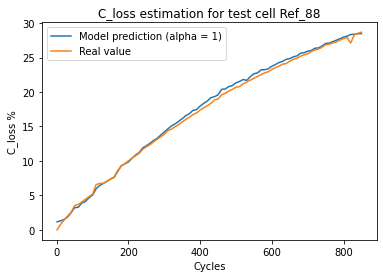

In [91]:
# plt.plot(cycles,100*np.array(responses3),label="Model prediction (alpha = 1/n)")
plt.plot(cycles,100*np.array(responses2),label="Model prediction (alpha = 1)")
plt.plot(cycles,100*np.array(targets),label="Real value")


plt.xlabel("Cycles")
plt.ylabel("C_loss %")
plt.legend()
plt.title(f"C_loss estimation for test cell {sample}")
plt.savefig(f'{sample}_prediciton.jpg')

In [37]:
!ls


Ref_88_MAE.jpg	       Ref_90_MAE.jpg	      __notebook_source__.ipynb
Ref_88_prediciton.jpg  Ref_90_prediciton.jpg  initialisation.pt


In [85]:
import time 

start = time.time()
response2=model2.eval()(data.to(device).float())[:,-1].mean().item()
print(time.time()-start)



0.00905752182006836
